# Проект - Построение модели выбора оптимальной упаковки для Яндекс.Маркет


Поскольку упаковку оплачивает покупатель, должен соблюдаться какой-то баланс между качеством товара, потребительскими и маркетинговыми функциями упаковки. Общий принцип, который рекомендуется, но не всегда соблюдается - упаковка не должна стоить дороже самого товара, и в масс-маркетинге - превышать 7-10% его стоимости.

## Описание данных

**Заказы (data.csv)**

Информация по заказам и товарам (sku), которые в них содержатся



- whs - код сортировочного центра

- orderkey - id заказа

- selected_cartontype - код упаковки, которая была выбрана пользователем

- box_num - количество коробок/ номер коробки ???

- recommended_cartontype - код упаковки, рекомендованной алгоритмом

- selected_carton - код упаковки, которая была выбрана пользователем (дубль)

- sel_calc_cube - объём выбранной упаковки

- recommended_carton - код упаковки, рекомендованной алгоритмом (дубль)

- pack_volume - рассчитанный объём упакованных товаров

- rec_calc_cube - (?) рекомендуемый объём упаковки

- goods_wght - вес товара

- sku - id товара

- who – упаковщик

- trackingid - id доставки

**SKU (sku.csv)**

Выгрузка id товаров и их размеров

- sku - id товара

- a, b, c, - размеры

**Карготипы товаров (sku_cargotypes.csv)**

Выгрузка id товаров и их карготипов

- sku -  id товара

- cargotype - карготип товара

**Описание карготипов (cargotype_info.csv)**

Таблица с идентификаторами карготипов и их описаниями

- argotype -  карготип

- description – описание

**Характеристики упаковок (carton.csv)**

Таблица с идентификаторами и линейными размерами упаковок

- CARTONTYPE - идентификатор (код) упаковки

- LENGTH, WIDTH, HEIGTH - линейные размеры упаковки

- DISPLAYFRACK - коробка есть на складе (не учитывать для наших целей)

**Стоимость упаковок (carton_price.xlsx)**

Таблица с идентификаторами упаковок и их стоимостью

- идентификатор (код) упаковки

- стоимость



## План

**1. Знакомство с данными**

    1.1 Импорт библиотек
    
    1.2 Загрузка данных
    
    1.3 Исследовательский анализ данных (размер, признаки, строки, типы данных, пропуски, аномалии, дубликаты, кореляция, распределение)
    
 **2. Предобработка данных**
    
    2.1 Преобразование типов данных 
    
    2.2 Разбиение на выборки
    
    2.3 Нормализация значений
    
 **3. Обучение моделей**
 
 
 **4. Вывод**
 
 **5. Отчет**

**************

## Знакомство с данными

### Импорт библиотек

In [1]:
 pip install progress 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9611 sha256=6d52cb6369e13ada7a9e9580f7660b12295db30445780c8f3a902435d77944b8
  Stored in directory: /root/.cache/pip/wheels/a2/68/5f/c339b20a41659d856c93ccdce6a33095493eb82c3964aac5a1
Successfully built progress


In [2]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 10.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import classification_report

from sklearn.utils.class_weight import compute_class_weight

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200
pd.options.display.float_format = '{:.2f}'.format
pd.options.mode.chained_assignment = None

**************

### Загрузка данных

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/portfolio/project/1_hackathon_pack/data.csv')
df_data.head()

,Unnamed: 0,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid
0,0,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
1,1,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
2,2,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
3,3,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
4,4,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24


In [6]:
df_sku = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/portfolio/project/1_hackathon_pack/sku.csv')
df_sku.head()

,Unnamed: 0,sku,a,b,c
0,0,8ba57dcdba9a58b0c4edd180bef6afc9,11.00,31.00,28.00
1,1,d9af6ce6f9e303f4b1a8cb47cde21975,29.00,14.00,40.00
2,2,8b91fd242bde88f0891380506d9c3caa,12.00,13.00,35.00
3,3,e8af308a7659e34194770d1e3a48e144,3.00,13.00,8.00
4,4,dc0e2542e122731217289b8e6d3bd3f8,96.00,18.00,56.00


In [7]:
df_sku_cargotypes = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/portfolio/project/1_hackathon_pack/sku_cargotypes.csv')
df_sku_cargotypes.head()

,Unnamed: 0,sku,cargotype
0,0,4862bf0e760a593b13f3f2fcf822e533,290
1,1,4862bf0e760a593b13f3f2fcf822e533,901
2,2,50d3c4fc66ad423b7feaadff2d682ee0,290
3,3,50d3c4fc66ad423b7feaadff2d682ee0,901
4,4,24ce9dba9f301ada55f60e25ee1498d2,290


In [8]:
df_sku_cargotypes_filtred = pd.merge(df_data[['sku']].drop_duplicates(), df_sku_cargotypes, on='sku', how='left') # дропаем тех которых у нас нет
sku_groups = df_sku_cargotypes_filtred.groupby('sku')['cargotype'].apply(list).reset_index()
#sku_groups = pd.merge(data[['sku']].drop_duplicates(), sku_groups, on='sku', how='left') # 
sku_groups

,sku,cargotype
0,00001dba9dfe01a550c23064c2b8e96f,[nan]
1,000198cfae123aef536f2fcf0b104049,"[290.0, 310.0, 410.0, 720.0, 750.0, 770.0]"
2,0003da69535758c817b78b64da05aae0,"[290.0, 310.0, 340.0, 750.0]"
3,0003fb4df9f32661d8772b1eac96e5ea,"[290.0, 600.0, 610.0, 950.0, 960.0, 970.0, 980.0]"
4,0005b21e4cba70e646f9f8f9a5d88d4e,"[290.0, 440.0, 441.0, 480.0, 490.0, 520.0, 690.0]"
...,...,...
86511,fffc51c2ad54a54667c8ab8d97ad081a,"[290.0, 310.0, 672.0, 690.0]"
86512,fffd12c4cbf8f9897d16e54f5eba1b39,"[290.0, 360.0, 640.0, 691.0]"
86513,fffdea5f8c5e0f0ca51112b725c8e699,"[290.0, 692.0, 901.0]"
86514,ffff026f5a46a375634c460083adf3dd,"[290.0, 410.0]"


In [9]:
sku_groups

,sku,cargotype
0,00001dba9dfe01a550c23064c2b8e96f,[nan]
1,000198cfae123aef536f2fcf0b104049,"[290.0, 310.0, 410.0, 720.0, 750.0, 770.0]"
2,0003da69535758c817b78b64da05aae0,"[290.0, 310.0, 340.0, 750.0]"
3,0003fb4df9f32661d8772b1eac96e5ea,"[290.0, 600.0, 610.0, 950.0, 960.0, 970.0, 980.0]"
4,0005b21e4cba70e646f9f8f9a5d88d4e,"[290.0, 440.0, 441.0, 480.0, 490.0, 520.0, 690.0]"
...,...,...
86511,fffc51c2ad54a54667c8ab8d97ad081a,"[290.0, 310.0, 672.0, 690.0]"
86512,fffd12c4cbf8f9897d16e54f5eba1b39,"[290.0, 360.0, 640.0, 691.0]"
86513,fffdea5f8c5e0f0ca51112b725c8e699,"[290.0, 692.0, 901.0]"
86514,ffff026f5a46a375634c460083adf3dd,"[290.0, 410.0]"


In [10]:
df_cargotype = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/portfolio/project/1_hackathon_pack/cargotype_info.csv')
df_cargotype.head()

,Unnamed: 0,cargotype,description
0,0,770.00,консервы
1,1,301.00,тяжеловесный и крупногабаритный 20кг
2,2,980.00,Требует обязательной маркировки
3,3,985.00,"Не требует наличия маркировки, но требует выво..."
4,4,990.00,Потребует обязательной маркировки в ближайшем ...


In [11]:
df_cargotype.description.value_counts()

2023-04-11                                                                           2
консервы                                                                             1
корма для животных                                                                   1
цифровой товар                                                                       1
меркурий                                                                             1
возможно вскрытие заводской упаковки покупателем                                     1
Терморежим 13-22                                                                     1
Склад КГТ (крупногабаритный товар)                                                   1
Склад МГТ (малогабаритный товар)                                                     1
Склад СГТ (среднегабаритный товар)                                                   1
многоместный товар                                                                   1
не требует упаковки                        

In [12]:
df_cargotype.query('description == "2023-04-11"')

,Unnamed: 0,cargotype,description
64,64,NaN,2023-04-11
67,67,NaN,2023-04-11


В таблице df_cargotype некорректное значение столбца **description** == 2023-04-11 удаляем, 2 строки

In [13]:
df_cargotype = df_cargotype[df_cargotype['description'] != '2023-04-11']

In [14]:
df_carton = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/portfolio/project/1_hackathon_pack/carton.csv')
df_carton.head()

,CARTONTYPE,LENGTH,WIDTH,HEIGHT,DISPLAYRFPACK
0,YMA,24.70,15.00,10.00,1
1,YMC,30.00,20.00,15.00,1
2,YME,30.00,30.00,44.50,1
3,YMF,35.00,25.00,15.00,1
4,YMG,44.70,30.00,20.00,1


In [15]:
carton_price = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/portfolio/project/1_hackathon_pack/carton_price.xlsx')
carton_price.head()

,Unnamed: 0,01.03.2023
0,MYA,1.11
1,MYB,2.30
2,MYC,3.62
3,MYD,6.92
4,MYE,8.06


Загружены 5 датасетов 
- df_data — Информация по заказам и товарам (sku), которые в них содержатся
- df_sku - Выгрузка id товаров и их размеров
- df_sku_cargotypes - Выгрузка id товаров и их карготипов
- df_cargotype - Таблица с идентификаторами карготипов и их описаниями
- df_carton - Таблица с идентификаторами и линейными размерами упаковок

Очевидно, что таблицы связаны между собой через данные столбцов. Для экономии ресурсов и удобной предобработки объеденим 4 датасета по схеме

- data.csv + sku.csv + sku_cargotypes.csv (**left**, по столбцу **sku**)
- df (новая таблица) + df_cargotype (**left**, по столбцу **cargotype**)

Таблицу df_carton пока оставим в стороне как справочную.

In [16]:
df = df_data.merge(df_sku, 'left', on = 'sku').merge(df_sku_cargotypes, 'left', on = 'sku').merge(df_cargotype, 'left', on = 'cargotype')

### Исследовательский анализ данных

#### Общая информация

In [17]:
df.shape

(1470178, 23)

Датасет состоит из 23 столбцов и 1470178 строк


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470178 entries, 0 to 1470177
Data columns (total 23 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Unnamed: 0_x            1470178 non-null  int64  
 1   whs                     1470178 non-null  int64  
 2   orderkey                1470178 non-null  object 
 3   selected_cartontype     1470178 non-null  object 
 4   box_num                 1470178 non-null  int64  
 5   recommended_cartontype  1470178 non-null  object 
 6   selected_carton         1470178 non-null  object 
 7   sel_calc_cube           1470178 non-null  int64  
 8   recommended_carton      1470178 non-null  object 
 9   pack_volume             1470178 non-null  int64  
 10  rec_calc_cube           1470178 non-null  int64  
 11  goods_wght              1470178 non-null  float64
 12  sku                     1470178 non-null  object 
 13  who                     1470178 non-null  object 
 14  tr

В датасете тип  данных float64, int64, object. Различное количесто объектов - нужно проверить наличие пропусков.

**************

#### Пропуски

In [19]:
df.isna().sum()

Unnamed: 0_x                  0
whs                           0
orderkey                      0
selected_cartontype           0
box_num                       0
recommended_cartontype        0
selected_carton               0
sel_calc_cube                 0
recommended_carton            0
pack_volume                   0
rec_calc_cube                 0
goods_wght                    0
sku                           0
who                           0
trackingid                    0
Unnamed: 0_y              13432
a                         13432
b                         13432
c                         13432
Unnamed: 0_x              10182
cargotype                 10182
Unnamed: 0_y              22025
description               22025
dtype: int64

In [20]:
23398/len(df)*100

1.5915079670624919

Пропусков 1.6% - некритично, удаляем

In [21]:
df = df.dropna()

In [22]:
df.isna().sum()

Unnamed: 0_x              0
whs                       0
orderkey                  0
selected_cartontype       0
box_num                   0
recommended_cartontype    0
selected_carton           0
sel_calc_cube             0
recommended_carton        0
pack_volume               0
rec_calc_cube             0
goods_wght                0
sku                       0
who                       0
trackingid                0
Unnamed: 0_y              0
a                         0
b                         0
c                         0
Unnamed: 0_x              0
cargotype                 0
Unnamed: 0_y              0
description               0
dtype: int64

In [23]:
len(df)

1444690

**************

#### Дубликаты

In [24]:
df.nunique()

Unnamed: 0_x              314614
whs                            8
orderkey                  151914
selected_cartontype           17
box_num                      235
recommended_cartontype        22
selected_carton               17
sel_calc_cube                 38
recommended_carton            22
pack_volume                 9484
rec_calc_cube                 45
goods_wght                  3794
sku                        80552
who                          393
trackingid                161755
Unnamed: 0_y               80552
a                            981
b                            690
c                            816
Unnamed: 0_x              330538
cargotype                     78
Unnamed: 0_y                  78
description                   78
dtype: int64

Количество уникальных значений в каждом столбце значительно меньше количества строк - значения много раз повторяются. Следует проверить на дубликаты.

In [25]:
df.duplicated().sum()

0

Удалим данные где выбор оператора и рекомендация системы не совпадали при выборе типа и размера упаковки.

In [26]:
df = df[df['selected_cartontype'] == df['recommended_cartontype']]
df = df[df['sel_calc_cube'] == df['rec_calc_cube']]

Удалим лишние столбцы (в т.ч. рекомендуемые - их мы в обучении использовать не будем), которые содержат уникальную, но ненужную для обучения моделей информацию и проведем проверку дубликатов повторно.

In [27]:
df.drop(['Unnamed: 0_x', 'whs', 'orderkey', 'recommended_cartontype', 'selected_carton', 'recommended_carton', 'who', 
'trackingid', 'sku', 'Unnamed: 0_y', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis= 1 , inplace= True)

In [28]:
df.duplicated().sum()

184345

In [29]:
df.duplicated().sum()/len(df)*100

53.218454183542974

Дубликатов 58,4% в объединенной таблице. Большое количесво объясняется добавлением строк во время объединения и дублированием части данных.

In [30]:
df = df.drop_duplicates()

In [31]:
df.duplicated().sum()

0

In [32]:
len(df)

162048

После удаления дубликатов и пропусков в таблице осталось 600887 строк

**************

#### Распределение непрерывных признаков, аномалии, выбросы

In [33]:
df.head()

,selected_cartontype,box_num,sel_calc_cube,pack_volume,rec_calc_cube,goods_wght,a,b,c,cargotype,description
129,MYC,1,8436,2484,8436,3.10,36.00,3.00,23.00,290.00,Склад МГТ (малогабаритный товар)
130,MYC,1,8436,2484,8436,3.10,36.00,3.00,23.00,340.00,не требует упаковки
131,MYC,1,8436,2484,8436,3.10,36.00,3.00,23.00,410.00,опасный Авиа
132,MYC,1,8436,2484,8436,3.10,36.00,3.00,23.00,480.00,химикаты
133,MYC,1,8436,2484,8436,3.10,36.00,3.00,23.00,485.00,бытовая химия


In [34]:
df.columns

Index(['selected_cartontype', 'box_num', 'sel_calc_cube', 'pack_volume',
       'rec_calc_cube', 'goods_wght', 'a', 'b', 'c', 'cargotype',
       'description'],
      dtype='object')

In [35]:
df[['sel_calc_cube', 'pack_volume',
       'goods_wght', 'a', 'b', 'c']].describe()

,sel_calc_cube,pack_volume,goods_wght,a,b,c
count,162048.00,162048.00,162048.00,162048.00,162048.00,162048.00
mean,11513.62,6947.13,1.51,20.99,12.38,15.16
std,16136.59,30614.46,4.51,26.95,12.28,13.74
min,0.00,0.00,0.00,0.10,0.01,0.10
25%,3449.00,475.00,0.12,8.00,4.50,7.00
50%,8436.00,1140.00,0.35,13.20,9.00,10.50
75%,13500.00,2856.00,0.88,22.10,17.60,19.00
max,108000.00,1815450.00,88.00,257.00,240.00,200.00


Аномалии не обнаружены

Text(0.5, 0.98, 'Распределение объёмов выбранных упаковок')

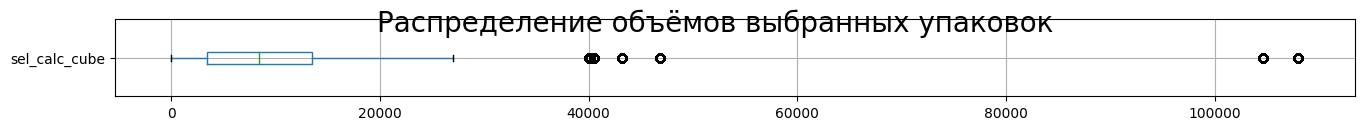

In [36]:
df.boxplot(['sel_calc_cube'], figsize = (16,1), vert=False) 
plt.suptitle('Распределение объёмов выбранных упаковок', size = 20)

Text(0.5, 0.98, 'Распределение объёмов выбранных упаковок')

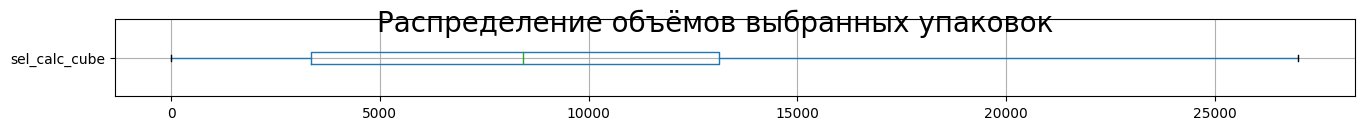

In [37]:
df[df['sel_calc_cube']<32000].boxplot(['sel_calc_cube'], figsize = (16,1), vert=False)       
plt.suptitle('Распределение объёмов выбранных упаковок', size = 20)

В распределении объёмов выбранных упаковок выбросами являются все значения больше 32000

Text(0.5, 0.98, 'Распределение рассчитанных объёмов упакованных товаров')

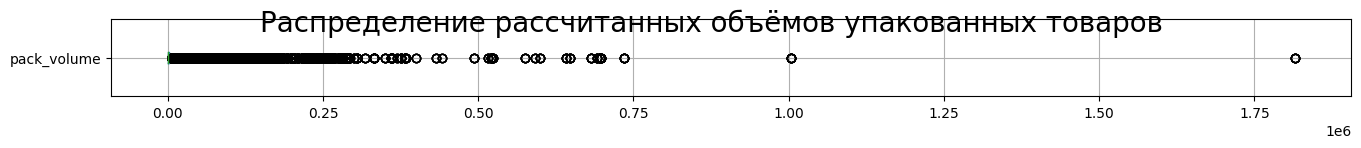

In [38]:
df.boxplot(['pack_volume'], figsize = (16,1), vert=False)       
plt.suptitle('Распределение рассчитанных объёмов упакованных товаров', size = 20)

array([[<Axes: title={'center': 'pack_volume'}>]], dtype=object)

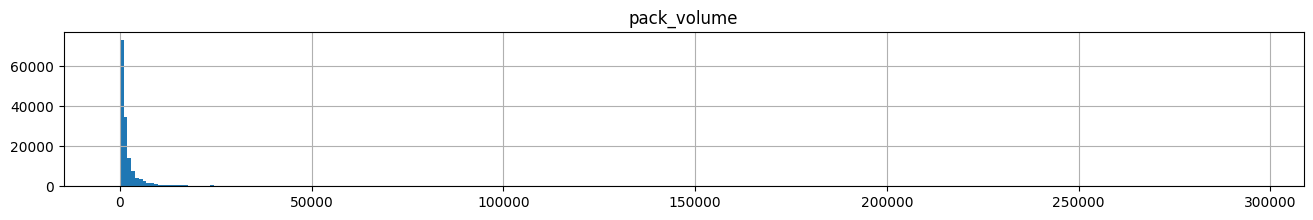

In [39]:
df[df['pack_volume']<300000].hist('pack_volume', bins =300, figsize = (16,2))

In [40]:
len(df[df['pack_volume']>300000])/len(df)*100

0.13576224328593997

В распределении рассчитанных объёмов упакованных товаров выбросы - все значения больше 300000. Это всего 0.04% 

Text(0.5, 0.98, 'Распределение размера a')

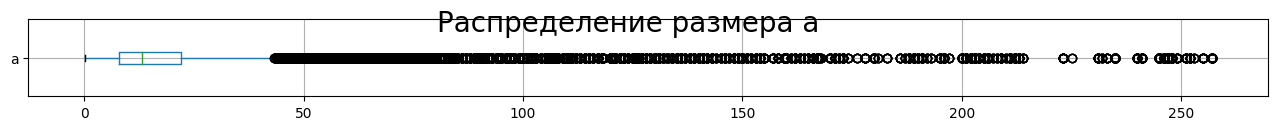

In [41]:
df.boxplot(['a'], figsize = (16,1), vert=False)       
plt.suptitle('Распределение размера a', size = 20)

array([[<Axes: title={'center': 'a'}>]], dtype=object)

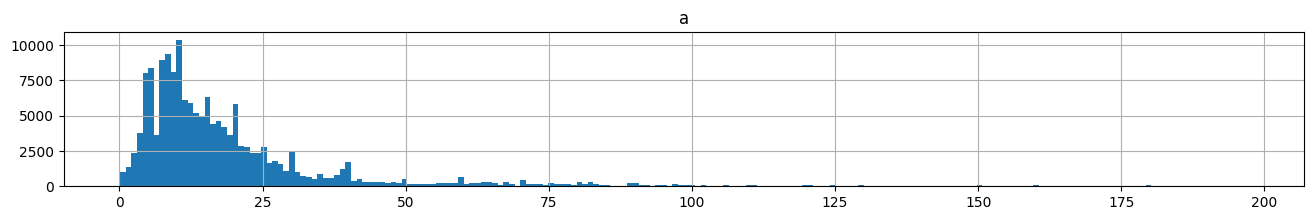

In [42]:
df[df['a']<200].hist('a', bins =200, figsize = (16,2))

Text(0.5, 0.98, 'Распределение размера a')

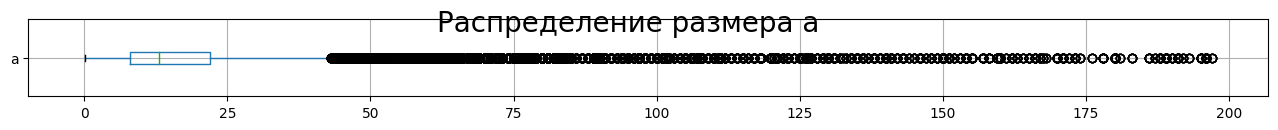

In [43]:
df[df['a']<200].boxplot(['a'], figsize = (16,1), vert=False)       
plt.suptitle('Распределение размера a', size = 20)

In [44]:
len(df[df['a']>200])/len(df)*100

0.5689672195892576

В распределении размерак 'a' выбросы - все значения больше 90. Это всего 0.57%

Text(0.5, 0.98, 'Распределение размера b')

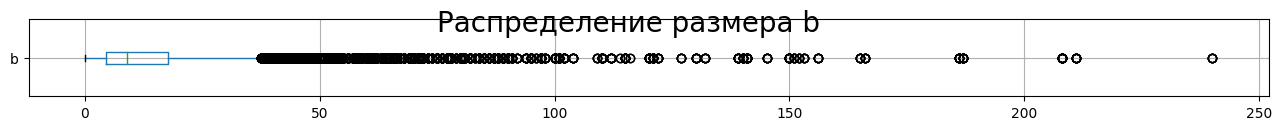

In [45]:
df.boxplot(['b'], figsize = (16,1), vert=False)       
plt.suptitle('Распределение размера b', size = 20)

array([[<Axes: title={'center': 'b'}>]], dtype=object)

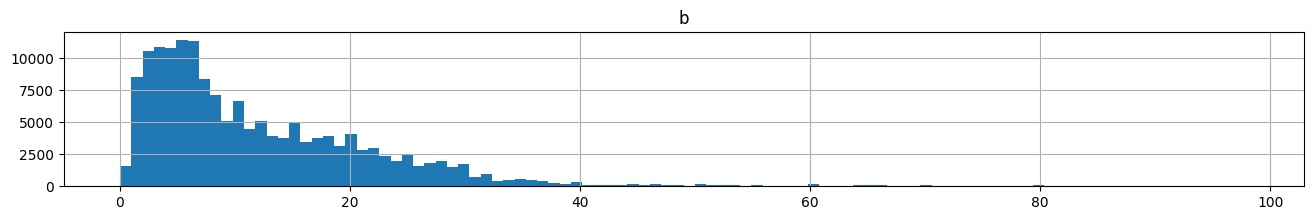

In [46]:
df[df['b']<100].hist('b', bins =100, figsize = (16,2))

Text(0.5, 0.98, 'Распределение размера b')

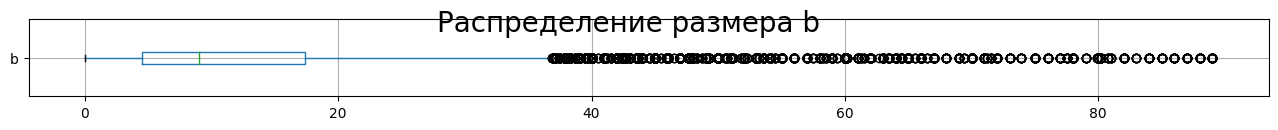

In [47]:
df[df['b']<90].boxplot(['b'], figsize = (16,1), vert=False)       
plt.suptitle('Распределение размера b', size = 20)

In [48]:
len(df[df['b']>90])/len(df)*100

0.25486275671406006

В распределении размерак 'b' выбросы - все значения больше 90. Это всего 0.25% 

Text(0.5, 0.98, 'Распределение размера c')

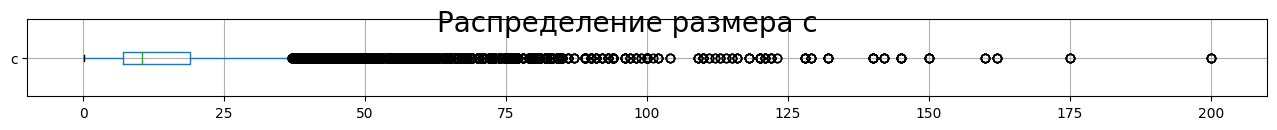

In [49]:
df.boxplot(['c'], figsize = (16,1), vert=False)       
plt.suptitle('Распределение размера c', size = 20)

array([[<Axes: title={'center': 'c'}>]], dtype=object)

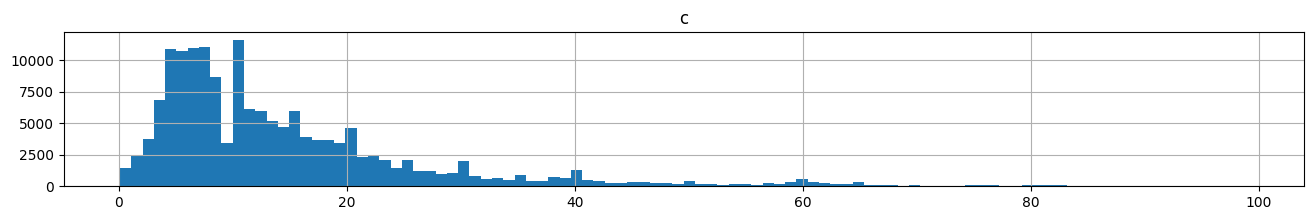

In [50]:
df[df['c']<100].hist('c', bins =100, figsize = (16,2))

Text(0.5, 0.98, 'Распределение размера c')

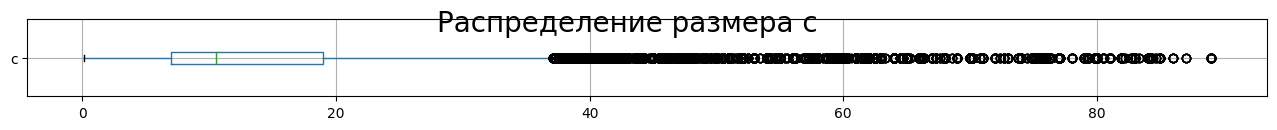

In [51]:
df[df['c']<90].boxplot(['c'], figsize = (16,1), vert=False)       
plt.suptitle('Распределение размера c', size = 20)

In [52]:
len(df[df['c']>90])/len(df)*100

0.1943868483412322

В распределении размерак 'c' выбросы - все значения больше 90. Это всего 0.19% 

## Предобработка данных

#### Удаление выбросов

In [53]:
df = df.query('sel_calc_cube < 32000')
df = df.query('pack_volume < 300000')
df = df.query('a < 200')
df = df.query('b < 200')
df = df.query('c < 200')

In [54]:
(162000 - len(df))/600887*100

1.8384488264848466

In [55]:
df.reset_index(drop= True , inplace= True )

Выбросы 1.8% удалены

Учитывая информацию в описании данных "DISPLAYFRACK - коробка есть на складе (не учитывать для наших целей)" - удаляем признак

In [56]:
df_carton.drop(['DISPLAYRFPACK'], axis= 1 , inplace= True)

In [57]:
df_carton.head()

,CARTONTYPE,LENGTH,WIDTH,HEIGHT
0,YMA,24.70,15.00,10.00
1,YMC,30.00,20.00,15.00
2,YME,30.00,30.00,44.50
3,YMF,35.00,25.00,15.00
4,YMG,44.70,30.00,20.00


In [58]:
df_carton.shape

(29, 4)

#### Кореляция

In [59]:
display(df.corr().style.background_gradient(cmap='summer'))

,box_num,sel_calc_cube,pack_volume,rec_calc_cube,goods_wght,a,b,c,cargotype
box_num,1.000000,-0.103023,0.084731,-0.103023,0.182920,0.335976,-0.017947,0.234358,-0.081601
sel_calc_cube,-0.103023,1.000000,-0.210917,1.000000,-0.210413,-0.204793,0.009266,-0.143604,0.060092
pack_volume,0.084731,-0.210917,1.000000,-0.210917,0.752588,0.518506,0.482632,0.546545,-0.070003
rec_calc_cube,-0.103023,1.000000,-0.210917,1.000000,-0.210413,-0.204793,0.009266,-0.143604,0.060092
goods_wght,0.182920,-0.210413,0.752588,-0.210413,1.000000,0.560726,0.390032,0.556542,-0.074379
a,0.335976,-0.204793,0.518506,-0.204793,0.560726,1.000000,0.037474,0.547764,-0.096118
b,-0.017947,0.009266,0.482632,0.009266,0.390032,0.037474,1.000000,0.057630,-0.042470
c,0.234358,-0.143604,0.546545,-0.143604,0.556542,0.547764,0.057630,1.000000,-0.044026
cargotype,-0.081601,0.060092,-0.070003,0.060092,-0.074379,-0.096118,-0.042470,-0.044026,1.000000


Проверка корреляции показала отсутствие слишком высокой линейной зависимости между признаками, кроме goods_wght и pack_volume. Здесь прямая линейная зависимость между столбцами sel_calc_cube и rec_calc_cube. Удалим столбец rec_calc_cube

In [60]:
df.drop(['rec_calc_cube'], axis= 1 , inplace= True)

In [61]:
df.shape

(150953, 10)

Проверим наличие нулевых данных

In [62]:
for i in df.columns:
  print(i, df[df[i] == 0][i].count())

selected_cartontype 0
box_num 0
sel_calc_cube 18019
pack_volume 10
goods_wght 10
a 0
b 0
c 0
cargotype 20
description 0


Пока оставим так

**************

**Вывод:**

Получены чистые данные в таблице, размер которой позволяет провести качественное обучение моделей с учетом объема оперативной памяти.

1. 4 датасета объеденены в один

2. Удалены пропускиданных
Удалены дубликаты. Большое количесво объясняется добавлением строк во время объединения 

3. Распределения значений в основном имеют положительную ассиметрию - длинный хвост справа. Небольшие значения, например длина упаковки, преобладают и их количество уменьшается с ростом значений.

4. Обнаруженные выбросы удалим в следующум разделе предобработки.


**************

Обучать будем три модели:
1. Определение размера упаковки
2. Определение типа упаковки
3. Определение совместимости товаров

**************

# Подготовка таблиц для определения размера упаковки

##  1. Определение размера упаковки

### Выделение целевого признака

Удаляем столбцы selected_cartontype	и pack_volume - прямое, явное влияние на таргет.

Согласно результатам предварительного обучения моделей и анализу feature importance - удалим столбец description (нулевое влияние)

In [63]:
x_1 = df.drop(['sel_calc_cube', 'selected_cartontype', 'pack_volume', 'description'] , axis=1)

Надеюсь, удалять 'selected_cartontype', 'sel_calc_cube', 'pack_volume' друг у друга, это не ошибка. Корреляция высокую зависимость не показывает

In [64]:
y_1 = df['sel_calc_cube']

С целью исключения категориальных признаков для обучения модели преобразовать категориальные признаки в численные поможет техника прямого кодирования, или отображения (англ. One-Hot Encoding, OHE)

### Разделение данных на обучающую 75% и тестовую выборку 25%

In [65]:
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x_1, y_1, test_size=0.25,shuffle=True, random_state=42,stratify=df['sel_calc_cube']
    )

**************

### Масштабирование признаков

Приведение непрерывных значений признаков к единому масштабу.
Для выборки train применяется метод fit и transform совместно - fit_transform, а для выборки test - transform

list_1 = list(train_1.columns)

numeric = list_1

scaler = StandardScaler()

train_1[numeric] = scaler.fit_transform(train_1[numeric])

test_1[numeric] = scaler.transform(test_1[numeric])

## 2. Определение типа упаковки

### Выделение целевого признака

In [67]:
x_2 = df.drop(['selected_cartontype', 'sel_calc_cube', 'pack_volume'] , axis=1)

С целью исключения категориальных признаков для обучения модели преобразовать категориальные признаки в численные поможет техника прямого кодирования, или отображения (англ. One-Hot Encoding, OHE)

In [69]:
x_2 = pd.get_dummies(x_2, drop_first=True)

In [75]:
y_2 = df['selected_cartontype']

In [78]:
y_2

0             MYC
1             MYC
2             MYC
3             MYC
4             MYC
           ...   
150948    NONPACK
150949    NONPACK
150950    NONPACK
150951    NONPACK
150952    NONPACK
Name: selected_cartontype, Length: 150953, dtype: object

### Разделение данных на обучающую 75% и тестовую выборку 25%

In [79]:
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(
    x_2, y_2, test_size=0.25,shuffle=True, random_state=42,stratify=df['selected_cartontype']
    )

**************

# Обучение моделей

## 1. Определение размера упаковки

In [ ]:
classes = np.unique(y_train_2)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_2)
class_weights = dict(zip(classes, weights))

### CatBoostClassifier

%%time 


model_cat_boost_1 = CatBoostClassifier(
        random_state=42,
        verbose = 100,
        leaf_estimation_method='Gradient',
        bootstrap_type="Bernoulli",
        loss_function='MultiClass',
        eval_metric='TotalF1'
        )


params = {
'early_stopping_rounds':[x for x in range(80, 100, 5)],    
'max_depth':[x for x in range(3, 5, 1)],    
'l2_leaf_reg':[x for x in range(7, 10, 1)],    
}


grid = RandomizedSearchCV(model_cat_boost_1, params, n_iter=1, cv=5)


grid.fit(x_train_1, y_train_1)


print('Лучший результат:')


print(grid.best_params_)


pred_model_cat_boost_1 = grid.predict(x_test_1)

In [93]:
%%time 

model_cat_boost_1 = CatBoostClassifier(
        random_state=42,
        early_stopping_rounds=100,
        #learning_rate=0.01, 
        leaf_estimation_method='Gradient',
        iterations=100,
        subsample=0.02,
        #max_depth=4,
        verbose=10,
        #l2_leaf_reg = 7,
        bootstrap_type="Bernoulli",
        #class_weights=class_weights,
        loss_function='MultiClass',
        eval_metric='TotalF1'
        )

model_cat_boost_1.fit(x_train_1, y_train_1)
pred_model_cat_boost_1 = model_cat_boost_1.predict(x_test_2)

0:	learn: 0.2131924	total: 127ms	remaining: 12.6s
10:	learn: 0.2072005	total: 1.7s	remaining: 13.7s
20:	learn: 0.2074422	total: 3.67s	remaining: 13.8s
30:	learn: 0.2092328	total: 4.84s	remaining: 10.8s
40:	learn: 0.2116044	total: 6.01s	remaining: 8.65s
50:	learn: 0.2119282	total: 7.18s	remaining: 6.9s
60:	learn: 0.2126780	total: 8.34s	remaining: 5.33s
70:	learn: 0.2135222	total: 9.5s	remaining: 3.88s
80:	learn: 0.2143502	total: 10.7s	remaining: 2.51s
90:	learn: 0.2148859	total: 11.9s	remaining: 1.17s
99:	learn: 0.2152533	total: 12.9s	remaining: 0us
CPU times: user 22.4 s, sys: 213 ms, total: 22.6 s
Wall time: 13.1 s


In [94]:
print(classification_report(y_test_2, pred_model_cat_boost_2))

              precision    recall  f1-score   support

         MYA       0.55      0.85      0.67      3231
         MYB       0.54      0.44      0.49      3214
         MYC       0.38      0.60      0.47      6150
         MYD       0.65      0.19      0.30      1272
         MYE       0.00      0.00      0.00       429
         MYF       0.00      0.00      0.00       275
     NONPACK       0.77      0.97      0.86      4055
     STRETCH       0.00      0.00      0.00       450
         YMA       0.35      0.64      0.45      5088
         YMC       0.36      0.33      0.34      5311
         YMF       0.38      0.01      0.03      3327
         YMG       0.38      0.09      0.14      2649
         YMW       0.61      0.05      0.10      2288

    accuracy                           0.46     37739
   macro avg       0.38      0.32      0.30     37739
weighted avg       0.46      0.46      0.40     37739



**************

### Дерево решений

In [ ]:
best_model_dtc = None
best_result_dtc = 0
for depth in range(1, 10):
    
    # обучение модели с заданным количеством деревьев est
    model_dtc_1 = DecisionTreeClassifier(random_state=42, max_depth=depth)
    
    # обучение модели на тренировочной выборке
    model_dtc_1.fit(x_train_1, y_train_1)
    
    # рассчет качества модели на валидационной выборке
    result_dtc_1 = model_dtc_1.score(x_test_1, y_test_1)
    if result_dtc_1 > best_result_dtc:
        
        # сохраняем наилучшую модель
        best_model_dtc_1 =  model_dtc_1
        
        #  сохраняем наилучшее значение метрики accuracy на валидационных данных
        best_result_dtc_1 = result_dtc_1

print("Score наилучшей модели решающее дерево на валидационной выборке:", best_result_dtc_1)
print(best_model_dtc_1)

In [97]:
predicted_dtc_1 = model_dtc_1.predict(x_test_1)

In [98]:
print(classification_report(y_test_1, predicted_dtc_1))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      4505
         998       0.41      0.87      0.56      2056
         999       0.23      0.05      0.08      1104
        1200       0.00      0.00      0.00        70
        1447       0.00      0.00      0.00       244
        1500       0.00      0.00      0.00        30
        2816       0.00      0.00      0.00        13
        3267       0.00      0.00      0.00       495
        3360       1.00      0.00      0.00      1011
        3449       0.47      0.73      0.57      3201
        3705       0.19      0.47      0.27      2485
        4068       0.17      0.00      0.00      1098
        4560       0.00      0.00      0.00         8
        7600       1.00      0.03      0.06        31
        8436       0.44      0.62      0.52      6142
        8525       0.00      0.00      0.00      1192
        8600       0.00      0.00      0.00       575
        9000       0.25    

In [100]:
importances_dtc_1= model_dtc_1.feature_importances_
feature_list = list(x_train_1.columns)

feature_results = pd.DataFrame({'feature': feature_list,
                                'importance': importances_dtc_1})

feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
feature_results

,feature,importance
0,a,0.52
1,c,0.19
2,b,0.16
3,goods_wght,0.13
4,box_num,0.00
5,cargotype,0.00


В разделе "Подготовка таблиц" удалим столбцы с нулевой важностью

**************

### Случайный лес

In [101]:
model_rfc_1 = RandomForestClassifier(random_state=42)

params = {   
    'max_depth':[x for x in range(1, 3, 1)]
}

grid = RandomizedSearchCV(model_rfc_1, params, n_iter=10, random_state=42, cv=15)
grid.fit(x_train_1, y_train_1)
print('Лучший результат:')
print(grid.best_params_)
predicted_rfc_1 = grid.predict(x_test_1)

Лучший результат:
{'max_depth': 2}


In [102]:
print(classification_report(y_test_1, predicted_rfc_1))

              precision    recall  f1-score   support

           0       0.79      0.97      0.87      4505
         998       0.00      0.00      0.00      2056
         999       0.00      0.00      0.00      1104
        1200       0.00      0.00      0.00        70
        1447       0.00      0.00      0.00       244
        1500       0.00      0.00      0.00        30
        2816       0.00      0.00      0.00        13
        3267       0.00      0.00      0.00       495
        3360       0.00      0.00      0.00      1011
        3449       0.00      0.00      0.00      3201
        3705       0.00      0.00      0.00      2485
        4068       0.00      0.00      0.00      1098
        4560       0.00      0.00      0.00         8
        7600       0.00      0.00      0.00        31
        8436       0.19      0.99      0.32      6142
        8525       0.00      0.00      0.00      1192
        8600       0.00      0.00      0.00       575
        9000       0.00    

**************

## 2. Определение типа упаковки

### CatBoostClassifier

In [82]:
%%time 

model_cat_boost_2 = CatBoostClassifier(
        random_state=42,
        early_stopping_rounds=100,
        #learning_rate=0.01, 
        leaf_estimation_method='Gradient',
        iterations=100,
        subsample=0.02,
        #max_depth=4,
        verbose=10,
        #l2_leaf_reg = 7,
        bootstrap_type="Bernoulli",
        #class_weights=class_weights,
        loss_function='MultiClass',
        eval_metric='TotalF1'
        )

model_cat_boost_2.fit(x_train_2, y_train_2)
pred_model_cat_boost_2 = model_cat_boost_2.predict(x_test_2)

0:	learn: 0.2532257	total: 424ms	remaining: 42s
10:	learn: 0.3465439	total: 3.79s	remaining: 30.7s
20:	learn: 0.3558692	total: 5.87s	remaining: 22.1s
30:	learn: 0.3655677	total: 8.02s	remaining: 17.9s
40:	learn: 0.3708817	total: 10.1s	remaining: 14.6s
50:	learn: 0.3786724	total: 12.3s	remaining: 11.9s
60:	learn: 0.3830691	total: 15.7s	remaining: 10.1s
70:	learn: 0.3896244	total: 18s	remaining: 7.33s
80:	learn: 0.3959870	total: 20.1s	remaining: 4.73s
90:	learn: 0.4014168	total: 22.3s	remaining: 2.21s
99:	learn: 0.4060705	total: 24.3s	remaining: 0us
CPU times: user 41.3 s, sys: 291 ms, total: 41.6 s
Wall time: 24.7 s


In [83]:
print(classification_report(y_test_2, pred_model_cat_boost_2))

              precision    recall  f1-score   support

         MYA       0.55      0.85      0.67      3231
         MYB       0.54      0.44      0.49      3214
         MYC       0.38      0.60      0.47      6150
         MYD       0.65      0.19      0.30      1272
         MYE       0.00      0.00      0.00       429
         MYF       0.00      0.00      0.00       275
     NONPACK       0.77      0.97      0.86      4055
     STRETCH       0.00      0.00      0.00       450
         YMA       0.35      0.64      0.45      5088
         YMC       0.36      0.33      0.34      5311
         YMF       0.38      0.01      0.03      3327
         YMG       0.38      0.09      0.14      2649
         YMW       0.61      0.05      0.10      2288

    accuracy                           0.46     37739
   macro avg       0.38      0.32      0.30     37739
weighted avg       0.46      0.46      0.40     37739



In [84]:
importances_2= model_cat_boost_2.feature_importances_
feature_list = list(x_train_2.columns)

feature_results = pd.DataFrame({'feature': feature_list,
                                'importance': importances_2})

feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
feature_results

,feature,importance
0,a,31.59
1,b,24.82
2,goods_wght,20.78
3,c,20.51
4,box_num,0.95
5,cargotype,0.73
6,description_упаковка в пленку,0.15
7,description_Склад МГТ (малогабаритный товар),0.12
8,description_Склад КГТ (крупногабаритный товар),0.09
9,description_бытовая химия,0.03


В разделе "Подготовка таблиц" удалим столбцы с нулевой важностью

**************

### Дерево решений

In [85]:
best_model_dtc = None
best_result_dtc = 0
for depth in range(1, 10):
    
    # обучение модели с заданным количеством деревьев est
    model_dtc_2 = DecisionTreeClassifier(random_state=42, max_depth=depth)
    
    # обучение модели на тренировочной выборке
    model_dtc_2.fit(x_train_2, y_train_2)
    
    # рассчет качества модели на валидационной выборке
    result_dtc_2 = model_dtc_2.score(x_test_2, y_test_2)
    if result_dtc_2 > best_result_dtc:
        
        # сохраняем наилучшую модель
        best_model_dtc_2 =  model_dtc_2
        
        #  сохраняем наилучшее значение метрики accuracy на валидационных данных
        best_result_dtc_2 = result_dtc_2

print("Score наилучшей модели решающее дерево на валидационной выборке:", best_result_dtc_2)
print(best_model_dtc_2)

Score наилучшей модели решающее дерево на валидационной выборке: 0.49770794138689417
DecisionTreeClassifier(max_depth=9, random_state=42)


In [86]:
predicted_dtc_2 = model_dtc_2.predict(x_test_2)

In [87]:
print(classification_report(y_test_2, predicted_dtc_2))

              precision    recall  f1-score   support

         MYA       0.62      0.95      0.75      3231
         MYB       0.53      0.62      0.57      3214
         MYC       0.52      0.57      0.54      6150
         MYD       0.78      0.36      0.49      1272
         MYE       0.64      0.31      0.42       429
         MYF       0.00      0.00      0.00       275
     NONPACK       0.94      0.93      0.94      4055
     STRETCH       0.75      0.41      0.53       450
         YMA       0.35      0.42      0.38      5088
         YMC       0.31      0.57      0.40      5311
         YMF       0.37      0.05      0.09      3327
         YMG       0.53      0.04      0.07      2649
         YMW       0.37      0.11      0.17      2288

    accuracy                           0.50     37739
   macro avg       0.52      0.41      0.41     37739
weighted avg       0.51      0.50      0.46     37739



In [91]:
importances_dtc_2= model_dtc_2.feature_importances_
feature_list = list(x_train_2.columns)

feature_results = pd.DataFrame({'feature': feature_list,
                                'importance': importances_dtc_2})

feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
feature_results

,feature,importance
0,a,0.46
1,b,0.23
2,c,0.19
3,goods_wght,0.11
4,description_упаковка в пленку,0.01
5,box_num,0.00
6,cargotype,0.00
7,description_не требует упаковки,0.00
8,description_цена низкая,0.00
9,description_техника и электроника,0.00


**************

### Случайный лес

In [89]:
model_rfc_2 = RandomForestClassifier(random_state=42)

params = {
    'n_estimators':[x for x in range(40, 60, 10)],
    'min_samples_split':[x for x in range(4, 8, 1)],
    'min_samples_leaf':[x for x in range(5, 9, 1)],    
    'max_depth':[x for x in range(7, 11, 1)]
}

grid = RandomizedSearchCV(model_rfc_2, params, n_iter=10, random_state=42, cv=15)
grid.fit(x_train_2, y_train_2)
print('Лучший результат:')
print(grid.best_params_)
predicted_rfc_2 = grid.predict(x_test_2)

Лучший результат:
{'n_estimators': 40, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 10}


In [92]:
print(classification_report(y_test_2, predicted_rfc_2))

              precision    recall  f1-score   support

         MYA       0.57      0.91      0.70      3231
         MYB       0.58      0.28      0.38      3214
         MYC       0.36      0.61      0.45      6150
         MYD       0.76      0.25      0.38      1272
         MYE       0.82      0.05      0.10       429
         MYF       0.00      0.00      0.00       275
     NONPACK       0.83      0.98      0.90      4055
     STRETCH       0.72      0.22      0.33       450
         YMA       0.34      0.66      0.45      5088
         YMC       0.35      0.32      0.33      5311
         YMF       0.54      0.01      0.01      3327
         YMG       0.45      0.04      0.08      2649
         YMW       0.60      0.05      0.09      2288

    accuracy                           0.46     37739
   macro avg       0.53      0.34      0.32     37739
weighted avg       0.50      0.46      0.40     37739



# Вывод

С целью построение модели выбора оптимальной упаковки для Яндекс.Маркетсти проведен исследовательский анализ данных, предобработка для искючения аномалий и трансформации таблиц.

Полученные данные использованы для обучения моделей CatBoostClassifier, DecisionTreeClassifier, RandomForestClassifier по определению размера и типа упаковки.

Перспектива улучшения

1. Требуется провести дополнительный анализ по улучшению метрик моделей

2. Дополнить алгоритмом учета совместимости упакованных товаров.

3. Учесть общий принцип, который рекомендуется, но не всегда соблюдается - упаковка не должна стоить дороже самого товара, и в масс-маркетинге - превышать 7-10% его стоимости.



